In [19]:
import sys
import os
sys.path.append("../../libraries/pvae/")
from pvae.manifolds.poincareball import PoincareBall
from pvae.manifolds.euclidean import Euclidean
from pvae.models.architectures import EncWrapped, DecWrapped
from pvae.distributions.wrapped_normal import WrappedNormal
from pvae.distributions.riemannian_normal import RiemannianNormal
from pvae.ops.manifold_layers import GeodesicLayer
from pvae.objectives import vae_objective
from torch.distributions.normal import Normal
sys.path.append("../../libraries/")
from HypHC.optim.radam import RAdam
from HypHC.utils.poincare import project
from HypHC.utils.visualization import plot_tree_from_leaves
from HypHC.utils.linkage import nn_merge_uf_fast_np, sl_from_embeddings
from HypHC.utils.metrics import dasgupta_cost
sys.path.append("../hyperLAI")
import math
import torch
from torch import nn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from models.hyperbolic_hc_loss import HyperbolicHCLoss
from models.encoder_decoder_architectures import *
from models.vae_model import vae_model
from torch.utils.data import SubsetRandomSampler, DataLoader, Subset
from torch.optim import Adam
from utils.sim_funcs import sim_func_dict
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model

enc_dec_dict = {"fc_wrapped_encoder": fc_wrapped_encoder, "fc_wrapped_decoder": fc_wrapped_decoder, "fc_geodesic_decoder": fc_geodesic_decoder} 
manifold_dict = {"PoincareBall": PoincareBall, "Euclidean": Euclidean}
distribution_dict = {"WrappedNormal": WrappedNormal, "Normal": Normal, "RiemannianNormal": RiemannianNormal}


# Load Model and Obtain Embeddings

In [20]:
model_dir = "/scratch/users/patelas/hyperLAI/models/vae_models/scratch/experiments_with_batchnorm/500000_initial/"
args = read_config(model_dir + "vae_config.json")

In [21]:
#Load validation dataset
dataset = HyperLoader(args["data_dir"], args["restrict_labels"], args["chromosome"])
train_indices, valid_indices, test_indices = train_valid_test(len(dataset), args["train_perc"], args["valid_perc"])
# variance_filter(dataset, train_indices, config["variance_filter"])
valid_data = Subset(dataset, valid_indices)
valid_loader = DataLoader(valid_data, batch_size=64)



In [13]:
#Define manifold and model
manifold = manifold_dict[args["manifold"]](args["embedding_size"])
enc_type, dec_type  = enc_dec_dict[args["enc_type"]], enc_dec_dict[args["dec_type"]]
encoder = enc_type(manifold, dataset[0][0].shape[-1], args["num_encoder_int_layers"], 
                   args["encoder_int_layer_sizes"], args["encoder_dropout_vals"], args["embedding_size"])
decoder = dec_type(manifold, dataset[0][0].shape[-1], args["num_decoder_int_layers"], 
                   args["decoder_int_layer_sizes"], args["decoder_dropout_vals"], args["embedding_size"])
model = vae_model(encoder, decoder, manifold, distribution_dict[args["posterior_dist"]],
                  distribution_dict[args["prior_dist"]], args["prior_mean"], args["prior_std"], args["temperature"], args["init_size"], args["min_scale"], args["max_scale"])


In [14]:
model_info = torch.load("%smodel.pt"%(model_dir))
model.load_state_dict(model_info["model_state"])

<All keys matched successfully>

In [15]:
#Run model on validation data
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
snps, embeddings, recons, suppop_labels, pop_labels = [], [], [], [], []
with torch.no_grad():
    for i, (snp_data, suppop, pop) in enumerate(valid_loader):
        embs = model.embed(snp_data.float().to(device))
        recon = model.generate(embs.to(device))
        snps.append(snp_data.cpu())
        embeddings.append(embs.cpu())
        recons.append(recon.cpu())
        suppop_labels.append(suppop)
        pop_labels.append(pop)

In [16]:
#Convert to numpy arrays
snps = torch.cat(snps).numpy()
embeddings = torch.cat(embeddings).numpy()
recons = torch.cat(recons).numpy()
suppop_labels = torch.cat(suppop_labels).numpy()
pop_labels = torch.cat(pop_labels).numpy()

# Plot Node Embeddings (Perhaps as PCA)

In [17]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot embeddings. Uncomment/comment as necessary depending on if you want raw embeddings or PCA
    '''
#     weights_pca = PCA().fit_transform(embeddings)
#     scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    scplot = sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.title("PCA of Embedding Weights")
    plt.xlabel("Embedding 1")
    plt.ylabel("Embedding 2")
    plt.title("Embedding Weights")

    if annotations is not None:
        for line in range(len(labels)):
#             if weights_pca[line,1] > -0.3:
#             if annotations[line] != "Hazara":
#                 continue
            scplot.text(embeddings[line,0]+0.001, embeddings[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


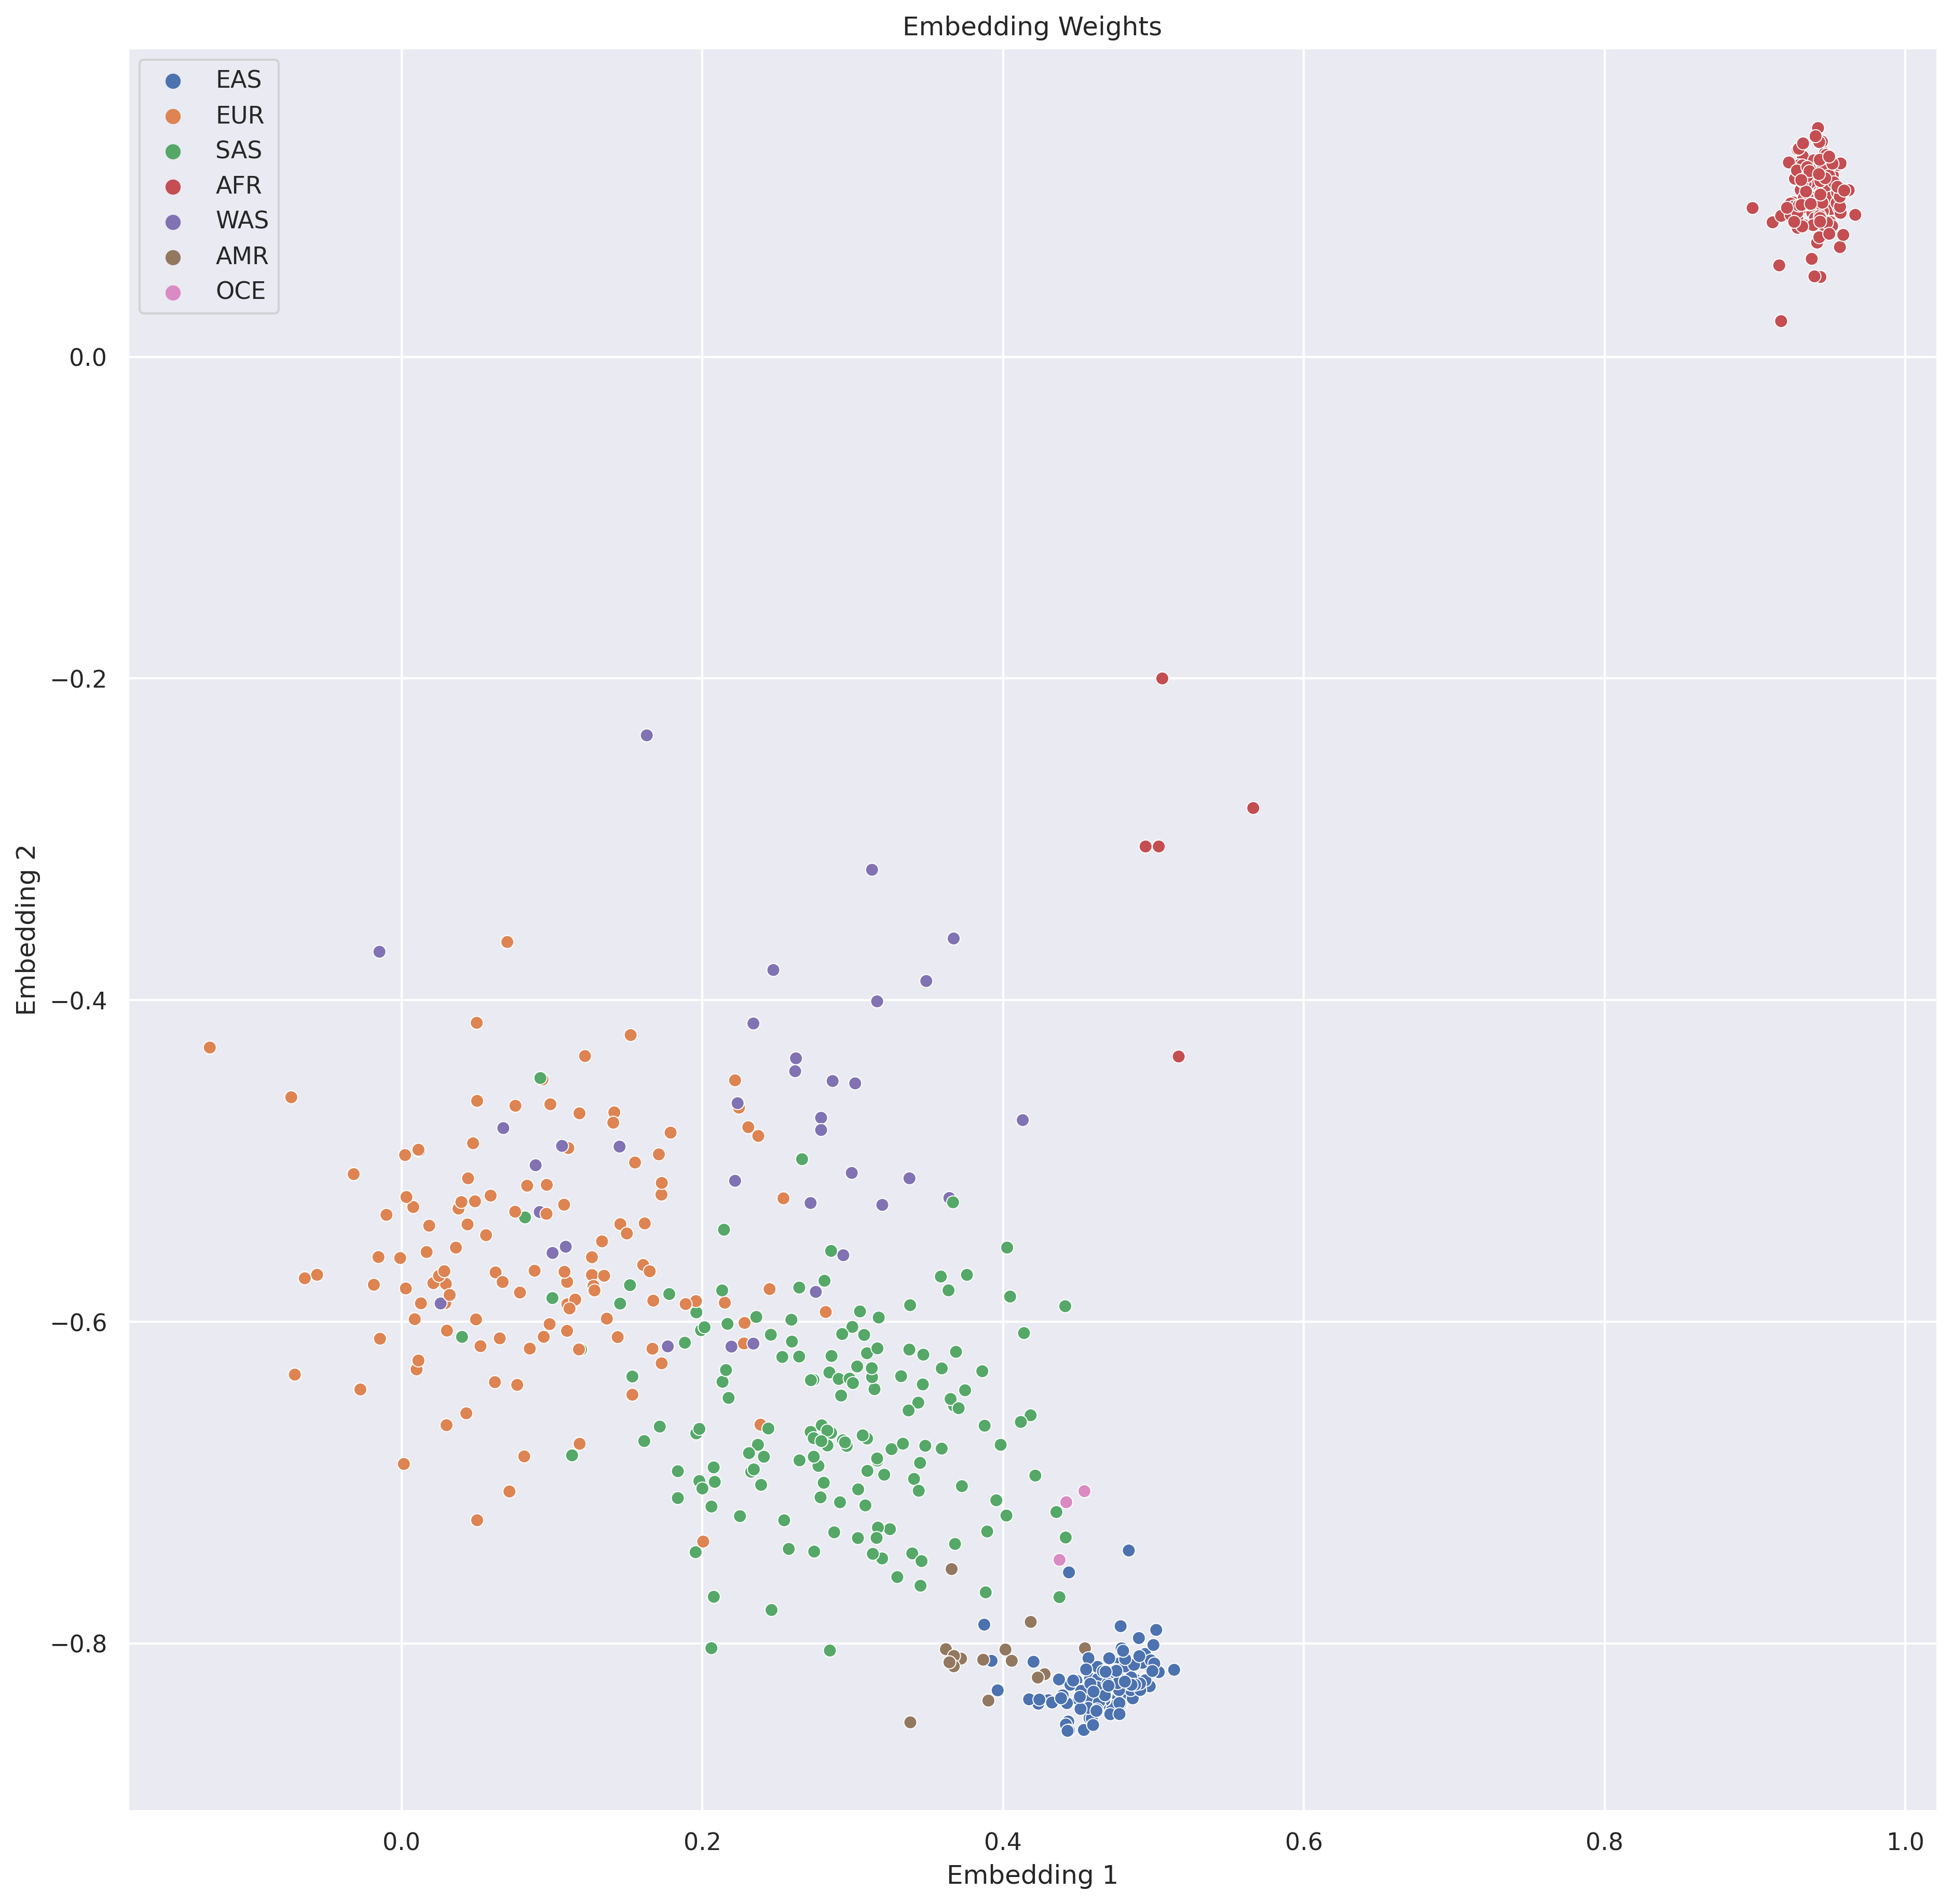

In [18]:
plt.figure(figsize=[15, 15], dpi=300)
sp_full = [dataset.suppop_label_index[x] for x in suppop_labels]
p_full = [dataset.pop_label_index[x] for x in pop_labels]
plot_weights_pca(embeddings, sp_full)
plt.show()

# Produce, Plot, and Evaluate Tree

In [10]:
def decode_tree(model, embeddings, device, fast_decoding):
    """Build a binary tree (nx graph) from leaves' embeddings. Assume points are normalized to same radius.
        Taken from HypHC repo (https://github.com/HazyResearch/HypHC)
    
    """
    with torch.no_grad():
        leaves_embeddings = model.HypHCLoss.normalize_embeddings(torch.tensor(embeddings).to(device))
        leaves_embeddings = project(leaves_embeddings).cpu()
    sim_fn = lambda x, y: torch.sum(x * y, dim=-1)
    if fast_decoding:
        parents = nn_merge_uf_fast_np(leaves_embeddings, S=sim_fn, partition_ratio=1.2)
    else:
        parents = sl_from_embeddings(leaves_embeddings, sim_fn)
    tree = nx.DiGraph()
    for i, j in enumerate(parents[:-1]):
        tree.add_edge(j, i)
    return tree


../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid val

../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid val

../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid val

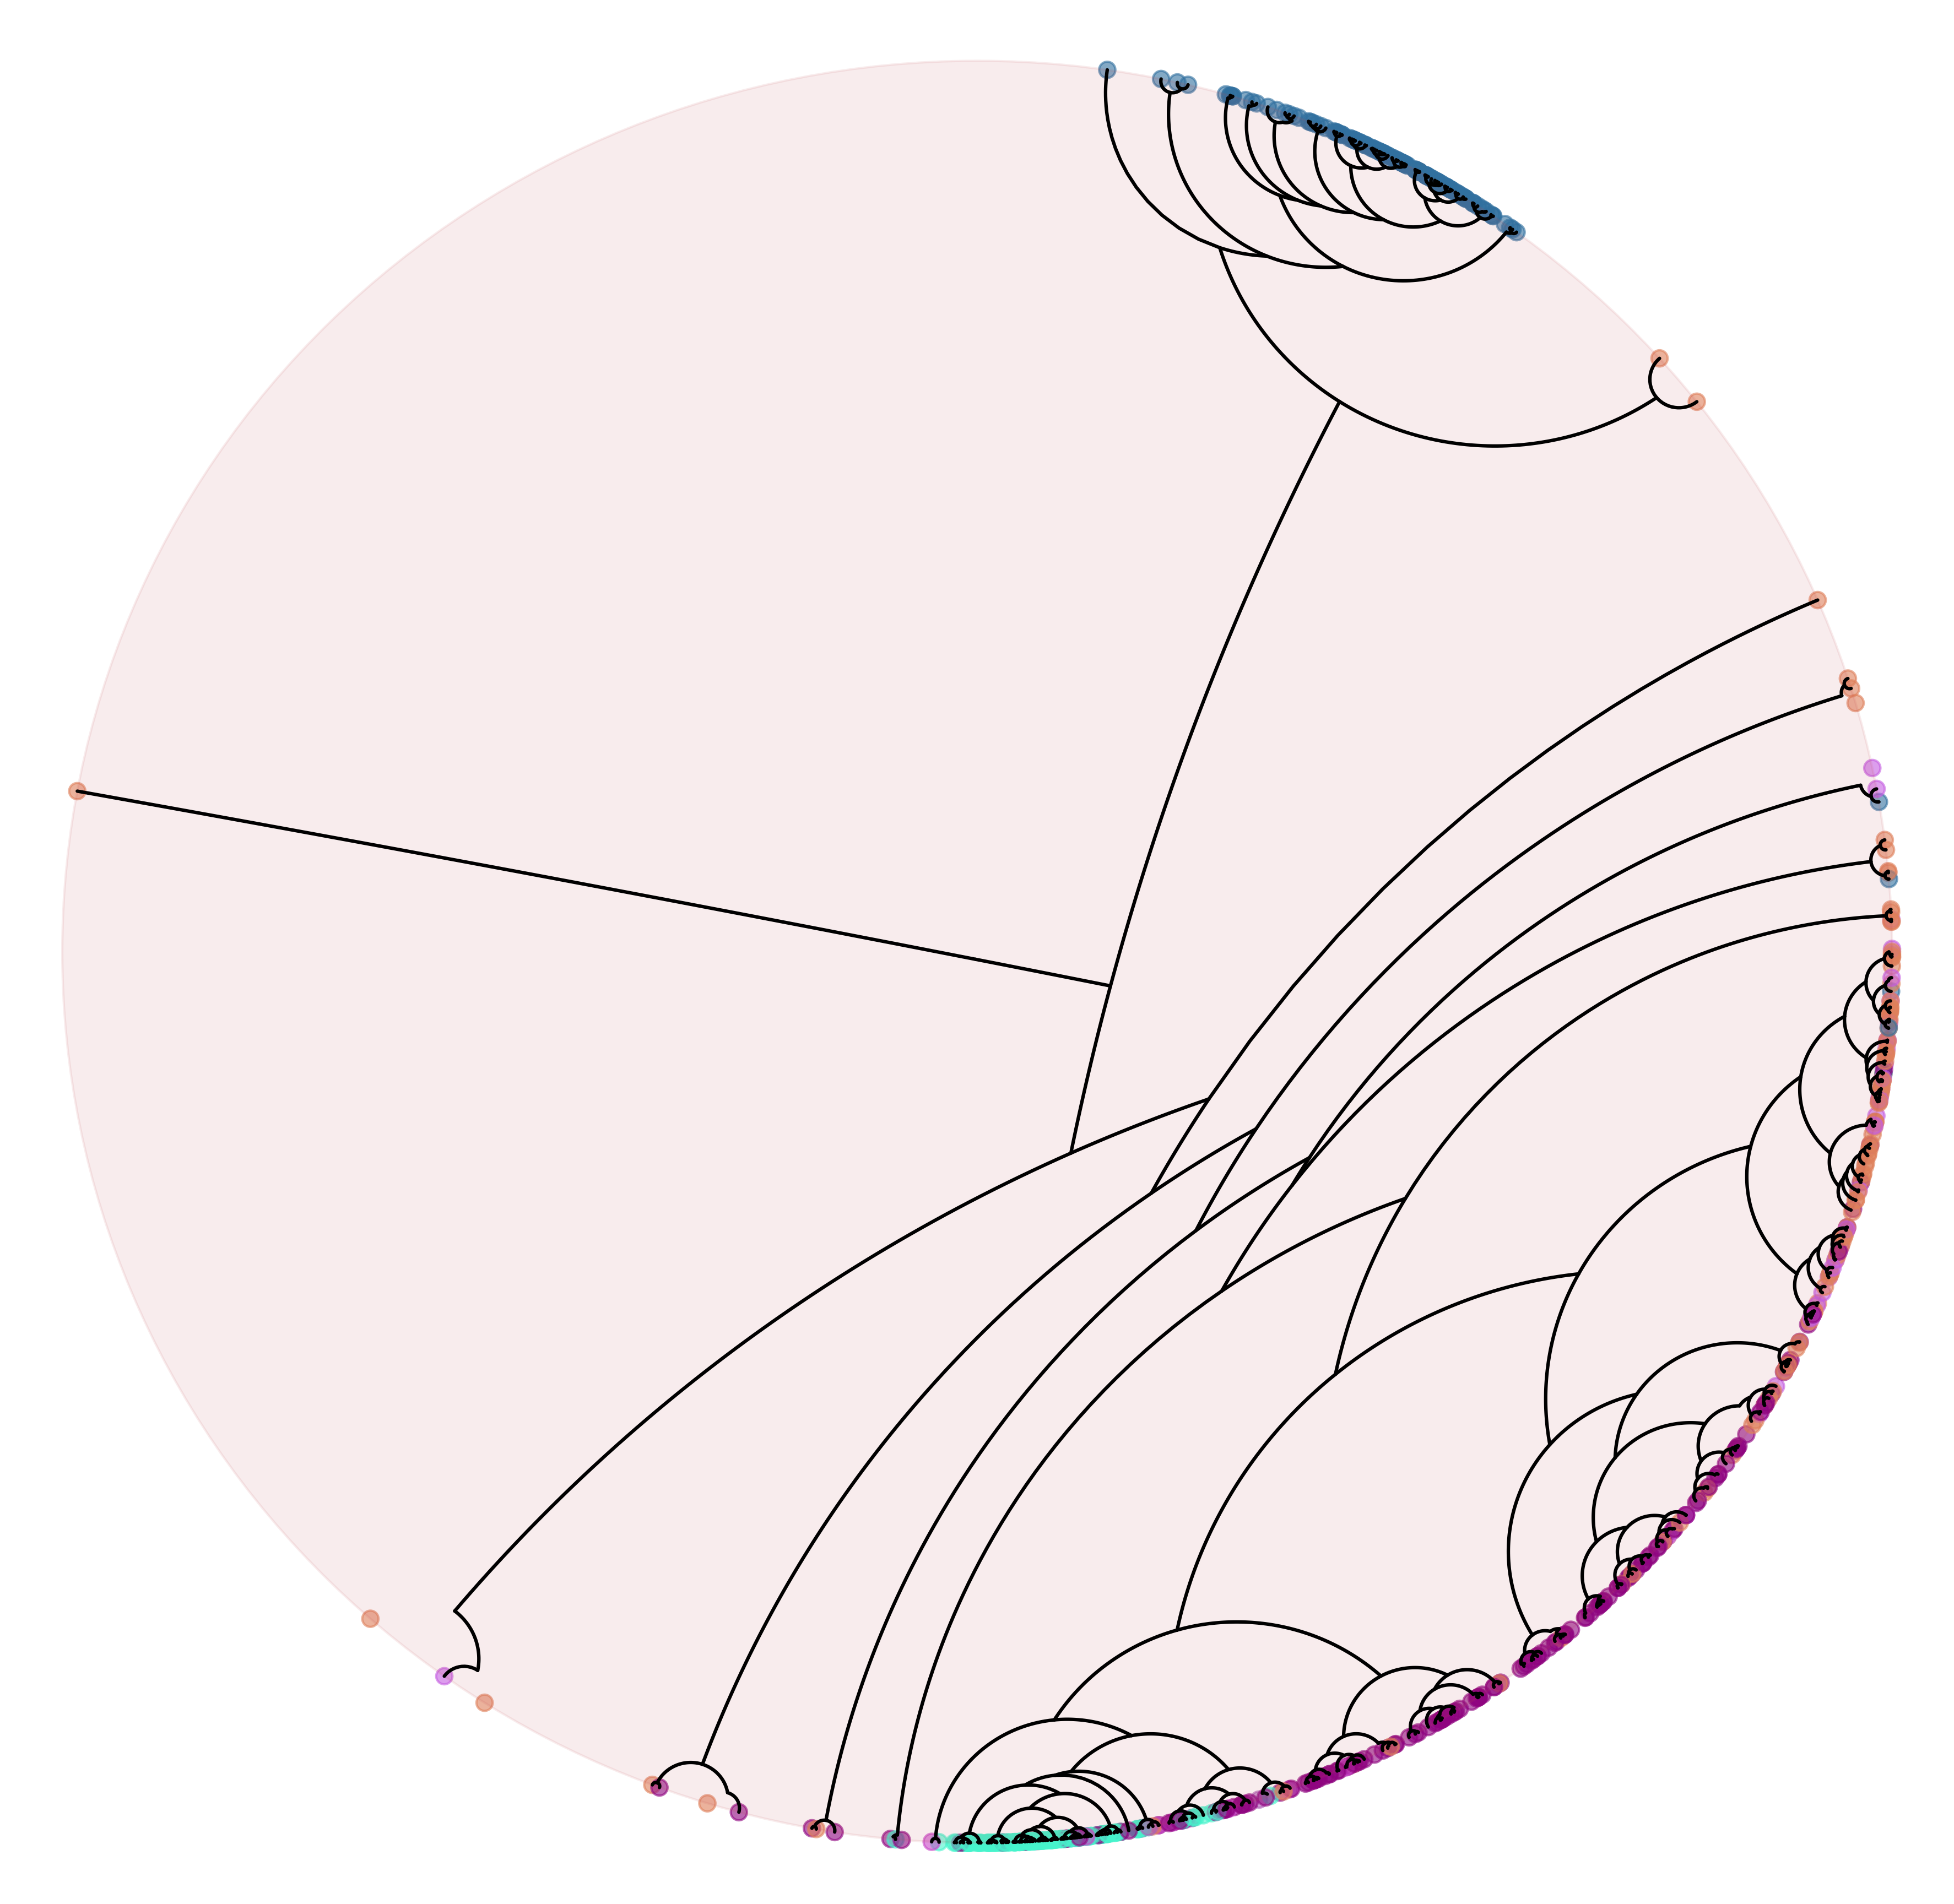

In [11]:
#Plot tree
embs_tree = embeddings
tree = decode_tree(model, embs_tree, device, True)
with torch.no_grad():
    embs_normed = model.HypHCLoss.normalize_embeddings(torch.tensor(embs_tree).to(device))
    leaves_embeddings = project(embs_normed).cpu().numpy()
fig = plt.figure(figsize=(15, 15), dpi=300)
ax = fig.add_subplot(111)
ax = plot_tree_from_leaves(ax, tree, leaves_embeddings * 100, labels=sp_full)

#Uncomment to add subpopulation labels - but it's very crowded
# for line in range(len(suppop_labels)):
#     ax.text(leaves_embeddings[line,0] * 100 +0.001, leaves_embeddings[line,1] * 100, 
#                  p_full[line], ha='left', 
#             color='black', va="baseline", rotation=45, size=8)

plt.show()


In [12]:
def make_pairwise_similarities(data, sim_func):
    '''
    Creates a similarity matrix from the SNP data using the specified similarity function
    This is a numpy version of the function used in training
    '''
    sim_matrix = np.zeros((data.shape[0], data.shape[0]))
    #Fill in matrix
    for ind in range(data.shape[0]):
        for ind2 in range(data.shape[0]):
            sim_matrix[ind][ind2] = sim_func(data[ind], data[ind2])
    #Divide by maximum for normalization
    sim_matrix /= np.amax(sim_matrix)
    return sim_matrix





In [13]:
sim_mat = make_pairwise_similarities(dataset.snps[valid_indices], lambda x,y: (np.sum(x==y)) / len(x))



In [14]:
#Calculates Dasgupta's cost of the tree
print(dasgupta_cost(tree, sim_mat))

68533335.94590001


# Test Reconstruction Ability

This part does a few different things, all relating to the differences between true and reconstructed data. It also runs PCA and inverse PCA for comparison purposes

In [10]:
#Some basic stats of the differences between true and reconstructed data
abs_diffs = np.absolute(snps-recons)
print(np.min(abs_diffs), np.mean(abs_diffs), np.max(abs_diffs))

0.2602673 0.32317993 0.73819625


In [11]:
#Reconstruction accuracy
preds = recons > 0.5
abs_preds = np.sum(snps == preds) / len(snps.flatten())
print(abs_preds)

0.9327412337148441


In [ ]:
plt.plot(sorted(np.mean(np.absolute(snps-recons),axis=1)))
plt.show()
plt.plot(sorted(np.min(np.absolute(snps-recons),axis=1)))
plt.show()
plt.plot(sorted(np.max(np.absolute(snps-recons),axis=1)))
plt.show()

In [172]:
#Compare reconstruction performance to reconstruction performance of PCA
recon_pca = PCA(n_components=100)
recon_pca.fit(dataset.snps[train_indices])
comps = recon_pca.transform(snps)
pca_reprod = recon_pca.inverse_transform(comps)
reprod_preds = pca_reprod > 0.5
print(np.sum(snps == reprod_preds) / len(snps.flatten()))

KeyboardInterrupt: 

# Test Fidelity of Reproduced Embeddings

This part takes synthetic embeddings (designed to reflect new "samples") and then runs them through the decoder and then the encoder. We then observe how the new embeddings reflect the original embedding space 

In [14]:
def decoder_acc_test(model, embeddings):
    '''
    Runs reconstruction and then re-embeds 
    '''
    model.eval()
    with torch.no_grad():
        recons = model.generate(embeddings.to(device))
        new_embs = model.embed(recons)
    return new_embs.cpu()

In [15]:
#We produce "fake embeddings" by adding random noise to current embeddings
fake_embs = embeddings + np.random.normal(0, 0.05, size=embeddings.shape)
#We then run them through the decoder and encoder
test_emb = torch.tensor(fake_embs).float()
recon_embs = decoder_acc_test(model, test_emb).numpy()

RuntimeError: CUDA out of memory. Tried to allocate 8.84 GiB (GPU 0; 10.76 GiB total capacity; 4.50 GiB already allocated; 5.18 GiB free; 4.63 GiB reserved in total by PyTorch)

In [20]:
#Take a look at some summary stats 
euc_dists = np.sqrt(np.sum((recon_embs - fake_embs)**2, axis=1))
print(np.min(euc_dists), np.mean(euc_dists), np.max(euc_dists))
axis_dists = np.absolute(recon_embs - fake_embs)


0.00486038066995642 0.22428612447664278 0.7038080058686911


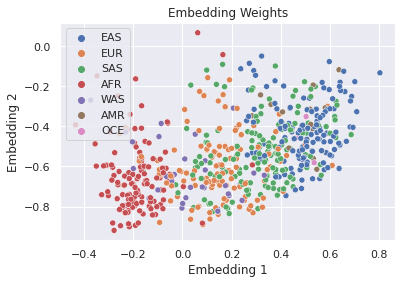

In [21]:
#Look at pattern of new embeddings and how it compares to the true pattern
plot_weights_pca(recon_embs, sp_full)
plt.show()

# Test Quality of Reconstructions

This part reconstructs data from embeddings, and then finds the minimum L1 distance between each reconstructed genotype and any true genotype. The embeddings provided can be either real or synthetic. 

In [16]:
def produce_recons(model, embeddings):
    model.eval()
    with torch.no_grad():
        recons = model.generate(torch.tensor(embeddings).float().to(device))
    return recons.cpu()

In [17]:
def l1_norm_diff(recon, real_snps):
    diffs = np.sum(np.abs(real_snps - (recon > 0.5).astype(float)), axis=1)
    return np.min(diffs)

In [22]:
rows_to_use = np.random.choice(len(embeddings), 20, replace=False)
fake_embs = embeddings[rows_to_use] + np.random.normal(0, 0.05, size=embeddings[rows_to_use].shape)
# fake_embs = embeddings[rows_to_use]
recons = produce_recons(model, fake_embs).numpy()
min_diffs = np.apply_along_axis(lambda x: l1_norm_diff(x, snps), 1, recons)

In [23]:
min_diffs

array([196413., 207998., 152773., 209343., 196632., 198284., 152791.,
       202825., 152784., 196037., 181067., 198289., 152781., 152893.,
       152781., 180894., 180917., 152773., 180915., 196974.])